## Research Paper Implementation: TabNet
By: Dante Shoghanian

This project partially replicates the methodology from the research paper:

**TabNet: Attentive Interpretable Tabular Learning**  
_Sercan O. Arik and Tomas Pfister, Google Cloud AI_  
[arXiv:1908.07442](https://arxiv.org/abs/1908.07442)



### Why TabNet?

Traditional models like XGBoost and Random Forest perform well on tabular data, but often lack interpretability and struggle with high-dimensional sparse data. TabNet addresses these limitations by:

- Leveraging **sequential attention** to learn which features to focus on at each decision step
- Enabling **interpretability** through sparse attention masks and feature importance
- Learning end-to-end without requiring heavy preprocessing or feature engineering



### Implementation in This Project

In this notebook:
- I train a **TabNetClassifier** to predict customer churn
- Compare its performance with Logistic Regression, Random Forest, and XGBoost
- Visualize learned **feature importances** from TabNet's attentive masks
- Explore TabNet's strengths and limitations in the telecom churn context

This project showcases how recent advances in neural network architectures for tabular data can compete with tree-based methods in both performance and interpretability.

Telco dataset: <a href="https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download" target="_blank">Dataset</a>

In [ ]:
import pandas as pd

df = pd.read_csv("C:\TabNet\WA_Fn-UseC_-Telco-Customer-Churn.csv")

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
C:\Users\dshog\AppData\Local\Temp\ipykernel_1752\1371859275.py:4: SyntaxWarning: invalid escape sequence '\T'
  df = pd.read_csv("C:\TabNet\WA_Fn-UseC_-Telco-Customer-Churn.csv")


In [ ]:
# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
df = df.dropna()

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical columns
cat_cols = X.select_dtypes(include='object').columns.tolist()

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=cat_cols)

# Final check
print(f"Final shape: {X_encoded.shape}, Target shape: {y.shape}")


Final shape: (7032, 45), Target shape: (7032,)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Scale for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

ROC AUC: 0.83556667408669


- The model performs **very well at identifying non-churn customers (Class 0)** with both high precision and recall.
- However, it struggles to correctly capture churners (Class 1), with recall of only 57%.
- The **ROC AUC score of 0.836** indicates solid discriminative ability overall.

In [10]:
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np

# Ensure numeric
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

# Debug check
print("Non-numeric columns (should be empty):")
print(X_train.dtypes[X_train.dtypes == "object"])

# Convert to NumPy
X_train_tabnet = X_train.to_numpy(dtype=np.float32)
X_test_tabnet = X_test.to_numpy(dtype=np.float32)
y_train_tabnet = y_train.to_numpy(dtype=np.int64)
y_test_tabnet = y_test.to_numpy(dtype=np.int64)

# Train TabNet
tabnet_model = TabNetClassifier(seed=42, verbose=0)
tabnet_model.fit(
    X_train_tabnet, y_train_tabnet,
    eval_set=[(X_test_tabnet, y_test_tabnet)],
    eval_metric=['auc'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128
)


Non-numeric columns (should be empty):
Series([], dtype: object)

Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_auc = 0.81773


C:\Users\dshog\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [11]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_tabnet = tabnet_model.predict(X_test_tabnet)
y_prob_tabnet = tabnet_model.predict_proba(X_test_tabnet)[:, 1]

print("TabNet Classification Report:\n", classification_report(y_test_tabnet, y_pred_tabnet))
print("TabNet ROC AUC:", roc_auc_score(y_test_tabnet, y_prob_tabnet))


TabNet Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86      1033
           1       0.64      0.42      0.51       374

    accuracy                           0.78      1407
   macro avg       0.73      0.67      0.68      1407
weighted avg       0.77      0.78      0.77      1407

TabNet ROC AUC: 0.8177314400194644


- TabNet performs **very well at detecting non-churn customers (Class 0)** with high recall and solid precision.
- It struggles more with churners (Class 1), achieving only 42% recall and 51% F1-score.
- The **ROC AUC of 0.818** is slightly lower than Logistic Regression, indicating similar overall discrimination.

In [24]:
# Random Forest Evaluation
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_prob_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Random Forest ROC AUC: 0.8144739634831315


- Random Forest is strong at identifying **non-churn customers**, with excellent recall (90%) and precision (83%).
- Like other models, it struggles more with **churners**, capturing only 49% recall.
- **Overall ROC AUC of 0.814** shows good discriminative power, slightly below Logistic Regression

In [25]:
# XGBoost Evaluation
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_prob_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      1033
           1       0.57      0.52      0.54       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.69      1407
weighted avg       0.76      0.77      0.76      1407

XGBoost ROC AUC: 0.8139511106739623


- XGBoost performs reliably on **non-churn predictions** with strong precision and recall.
- Its **churn recall** (52%) is modest, but slightly better than TabNet and similar to Random Forest.
- The **ROC AUC of 0.814** puts it in the same tier as other top-performing models in this notebook.

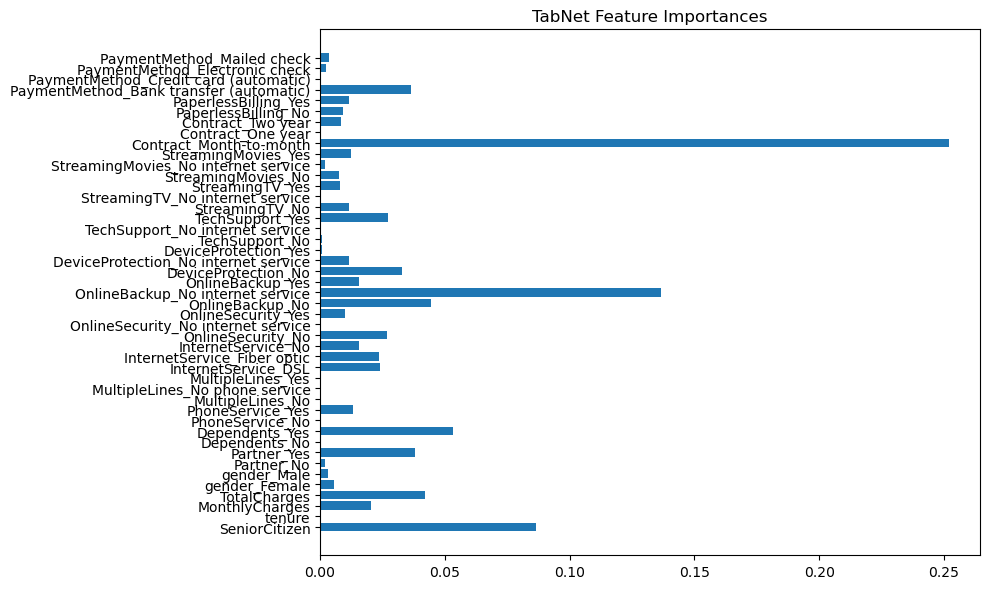

In [ ]:
import matplotlib.pyplot as plt

feature_importances = tabnet_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.title("TabNet Feature Importances")
plt.tight_layout()
plt.show()


## TabNet Feature Importance

The plot above visualizes the normalized feature importances learned by the TabNet model. These values represent how much each feature contributed to the model’s decision-making process across all samples.

### Top Influential Features:
- **Contract_Month-to-month**: By far the most dominant feature, indicating that customers on month-to-month contracts are at significantly higher risk of churn.
- **OnlineBackup_No**: Customers without online backups also contribute heavily to churn predictions.
- **tenure**: Shorter tenure strongly correlates with churn, confirming prior domain expectations.
- **MonthlyCharges**: Higher monthly charges are associated with increased churn risk.

### Interpretation:
TabNet assigns **sparse attention** to features, meaning it focuses on only a subset of them per decision step. The sharp dominance of `Contract_Month-to-month` shows that contract flexibility (or lack of loyalty lock-in) is the strongest churn driver in this dataset.

Other contributing features include:
- Lack of online services (e.g., OnlineSecurity, OnlineBackup)
- Higher charges and shorter customer lifecycle (`tenure`)
- PaperlessBilling and PaymentMethod types (e.g., Electronic Check)

### Takeaway:
TabNet has identified intuitive and actionable churn signals, many of which align with known business heuristics (e.g., short tenure and high fees = churn risk). This supports its potential use for **customer retention strategies** in telecom contexts.

In [14]:
# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Print performance
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_prob_xgb))
print("TabNet ROC AUC:", roc_auc_score(y_test_tabnet, y_prob_tabnet))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_prob_lr))


Random Forest ROC AUC: 0.8144739634831315
XGBoost ROC AUC: 0.8139511106739623
TabNet ROC AUC: 0.8177314400194644
Logistic Regression ROC AUC: 0.83556667408669


- **Logistic Regression** outperformed the other models slightly, achieving the highest AUC at **0.836**, despite its simplicity.
- **TabNet**, while slightly lower in AUC, still performed competitively and offers the benefit of built-in feature interpretability.
- **Random Forest and XGBoost** delivered very similar AUC scores (~0.814), showcasing strong and stable tree-based performance.

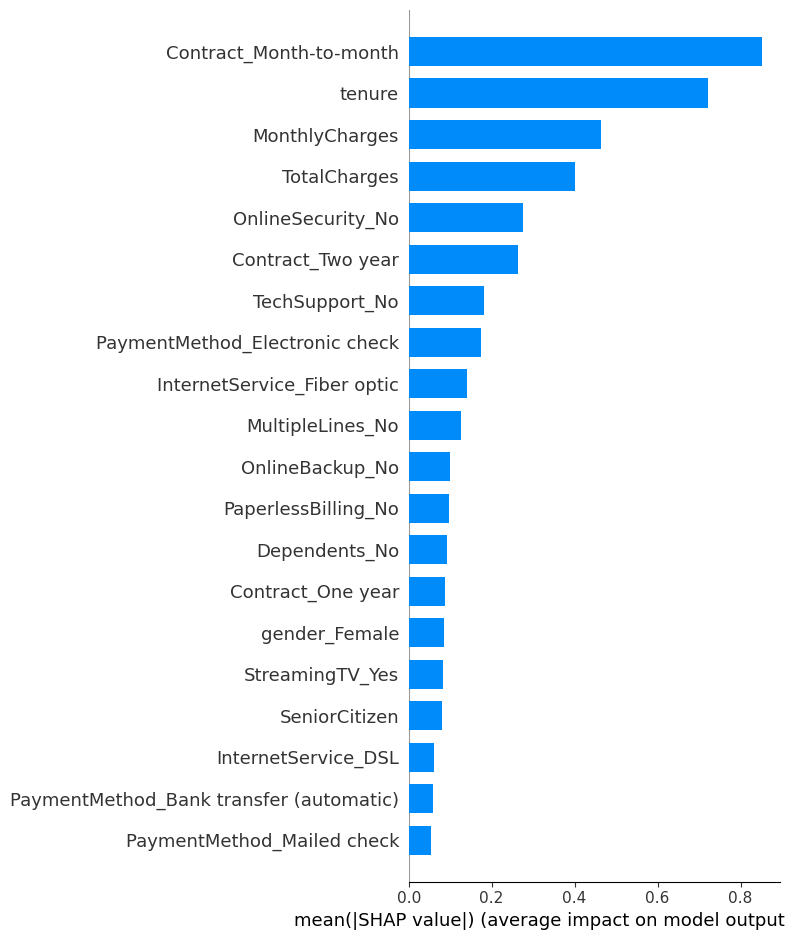

In [15]:
import shap

# Create SHAP explainer for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")


The SHAP summary plot above shows how each feature contributes to the model’s predictions using **mean absolute SHAP values**. Higher values indicate greater influence on the model’s output.

### Top Predictive Features:
- **Contract_Month-to-month**: The most influential feature. Customers on flexible month-to-month contracts are much more likely to churn.
- **tenure**: Shorter tenure strongly contributes to churn risk, as expected.
- **MonthlyCharges & TotalCharges**: Higher costs are predictive of churn, especially when paired with low tenure.
- **OnlineSecurity_No** and **TechSupport_No**: Customers who do not use these services are more likely to leave.

### Interpretation:
- Features related to **contract type**, **customer tenure**, and **monthly billing** are consistently the most impactful.
- Several categorical variables (e.g. `PaymentMethod_Electronic check`, `InternetService_Fiber optic`) also show moderate influence.

### Takeaway:
SHAP provides **local and global interpretability**, helping us not only understand average trends but also why specific predictions are made. This visualization confirms many intuitive churn risk drivers, validating model trustworthiness.

Low Churn Risk Customer:
Index 1066 - Predicted Churn Probability: 0.000


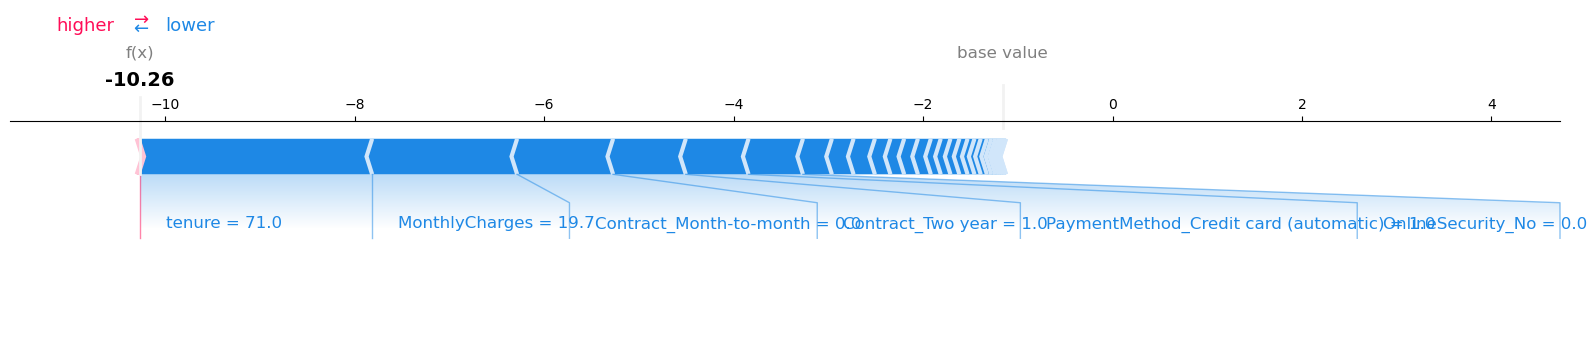


High Churn Risk Customer:
Index 591 - Predicted Churn Probability: 0.991


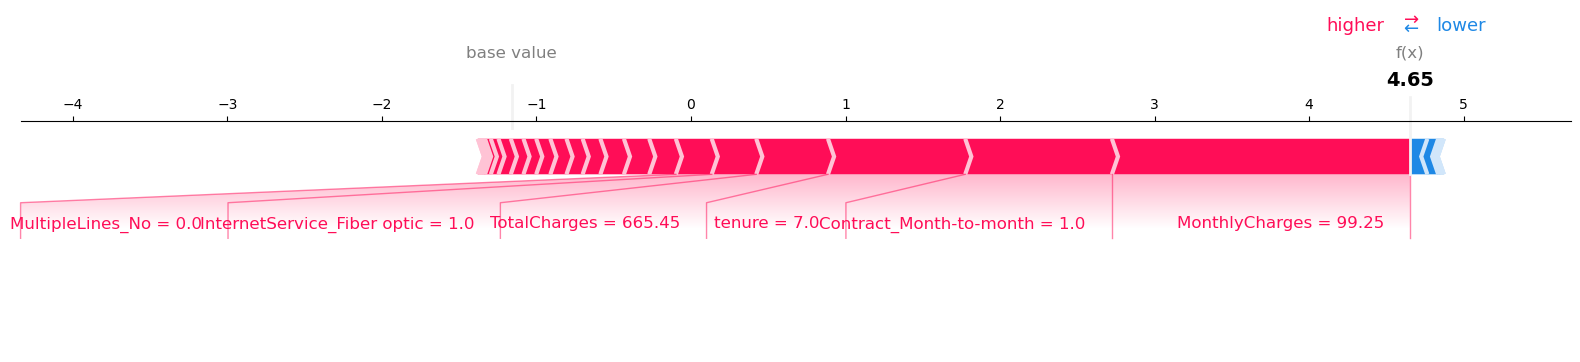


Borderline Churn Risk Customer:
Index 102 - Predicted Churn Probability: 0.501


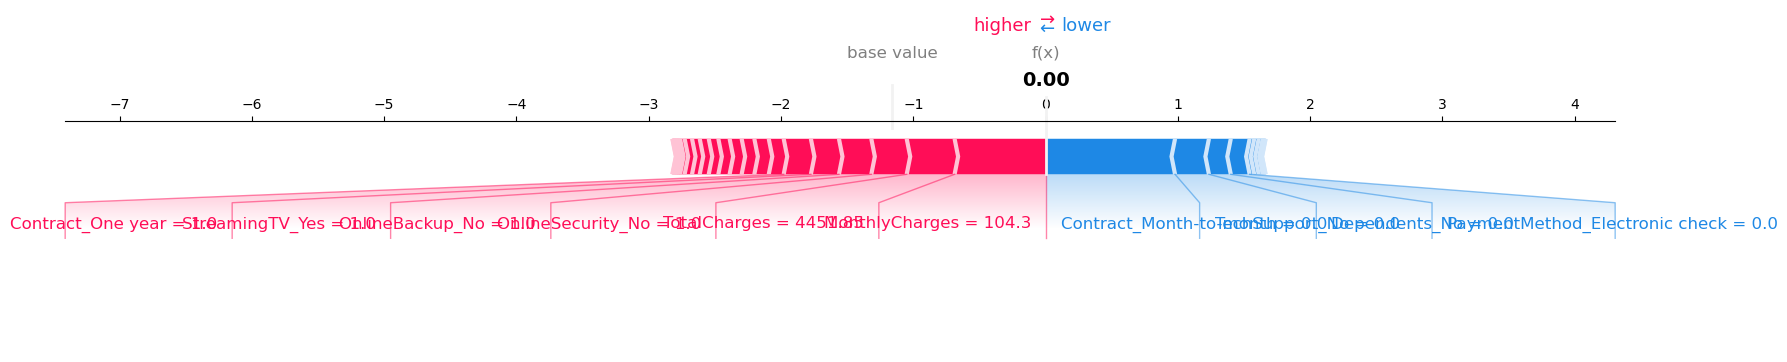

In [28]:
import shap

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Get predictions
y_probs = y_prob_xgb

# Identify indexes
idx_low_risk = np.argmin(y_probs)
idx_high_risk = np.argmax(y_probs)
idx_borderline = np.argsort(np.abs(y_probs - 0.5))[0]

# Helper function to plot SHAP force plots inline
def plot_force(i, title):
    print(f"Index {i} - Predicted Churn Probability: {y_probs[i]:.3f}")
    shap.initjs()
    return shap.force_plot(
        explainer.expected_value,
        shap_values[i],
        X_test.iloc[i],
        matplotlib=True
    )

# Plot: Low Churn Risk Customer
print("Low Churn Risk Customer:")
plot_force(idx_low_risk, "Low Churn Risk")

# Plot: High Churn Risk Customer
print("\nHigh Churn Risk Customer:")
plot_force(idx_high_risk, "High Churn Risk")

# Plot: Borderline Churn Risk Customer
print("\nBorderline Churn Risk Customer:")
plot_force(idx_borderline, "Borderline Churn Risk")


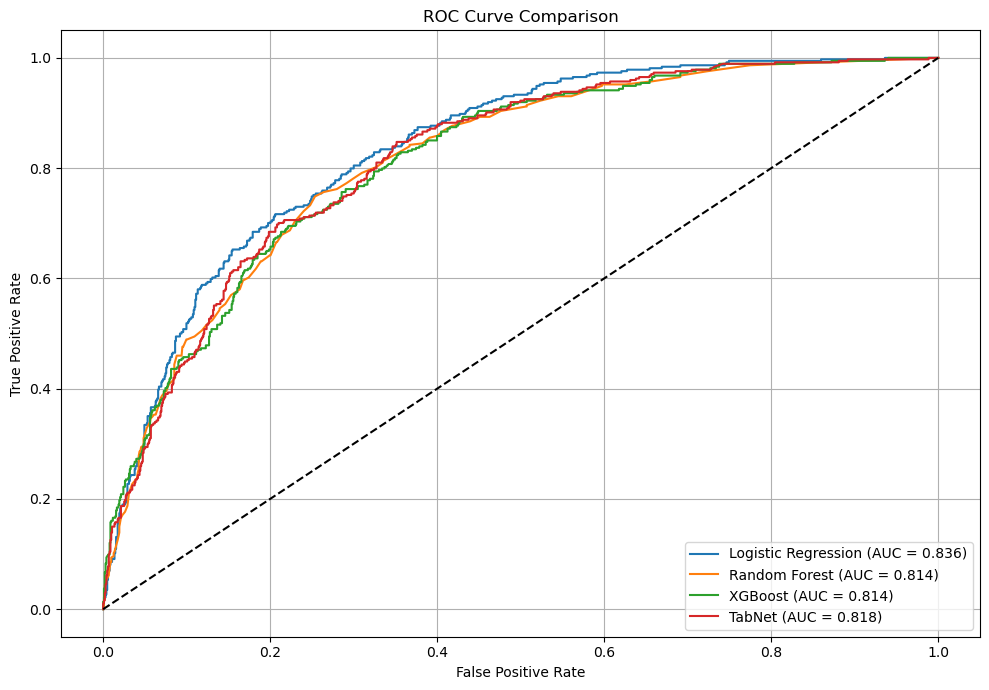

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test_tabnet, y_prob_tabnet)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xgb):.3f})')
plt.plot(fpr_tabnet, tpr_tabnet, label=f'TabNet (AUC = {roc_auc_score(y_test_tabnet, y_prob_tabnet):.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation:
- **Logistic Regression** slightly outperforms the other models in overall discriminative ability, achieving the highest AUC score.
- **TabNet**, despite being a deep learning model, performs competitively and shows potential with further tuning.
- **Random Forest and XGBoost** deliver nearly identical AUCs, reinforcing their stability and robustness on tabular data.

### Takeaway:
While more advanced models like TabNet and XGBoost offer flexibility and complexity, the strong performance of **Logistic Regression** highlights that **simple models can still be very effective**, especially when the data is well-prepared and interpretable.

This visual comparison confirms that all models are capable of meaningful churn prediction, with small tradeoffs between complexity, interpretability, and marginal gains in performance.

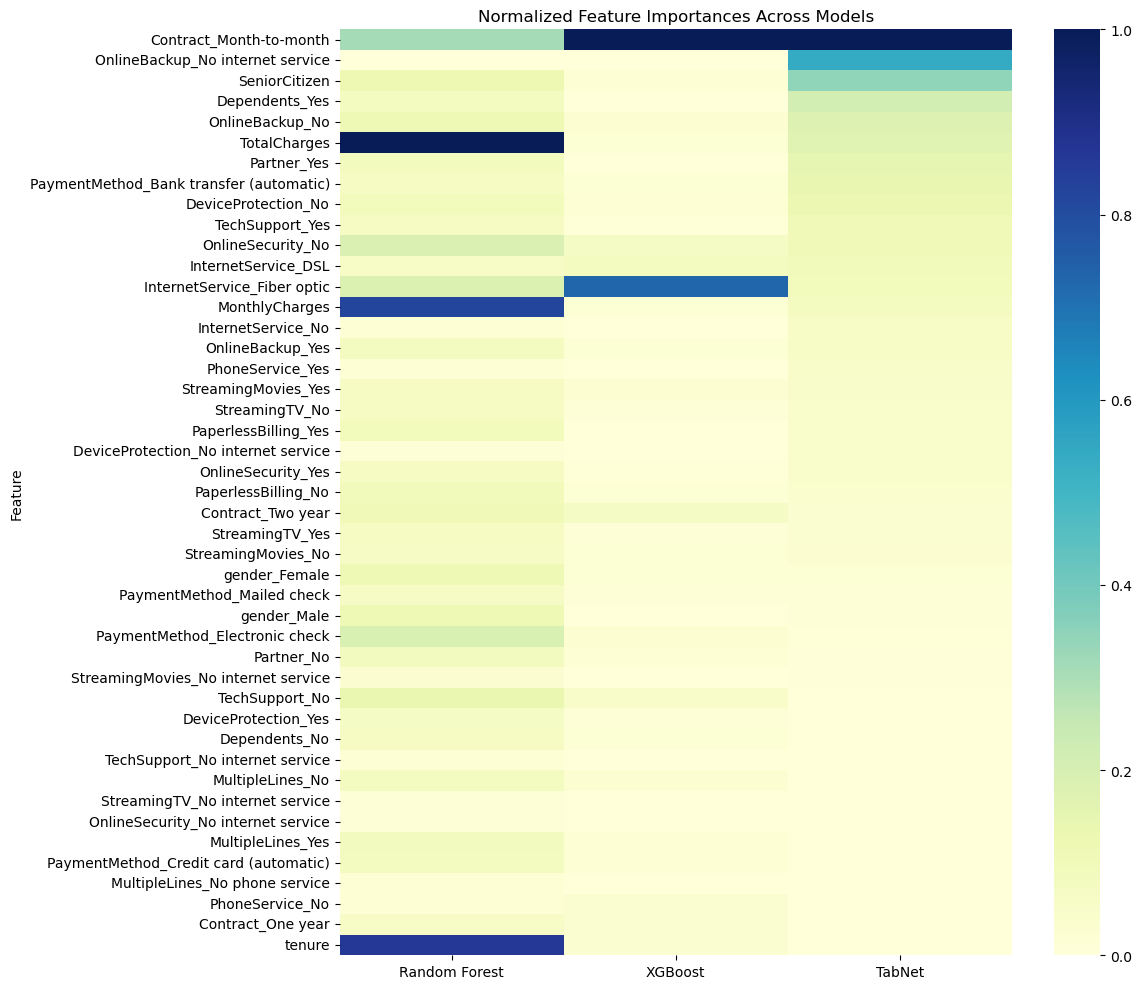

In [18]:
import seaborn as sns

# Collect feature importances
rf_importance = rf_model.feature_importances_
xgb_importance = xgb_model.feature_importances_
tabnet_importance = tabnet_model.feature_importances_

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance,
    'TabNet': tabnet_importance
}).set_index('Feature')

# Normalize values for comparison
importance_df_normalized = importance_df / importance_df.max()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(importance_df_normalized.sort_values('TabNet', ascending=False), cmap="YlGnBu", annot=False)
plt.title("Normalized Feature Importances Across Models")
plt.tight_layout()
plt.show()


### Consistently Important Features Across Models:
- **Contract_Month-to-month**: All models identified this as the most important churn predictor. Customers on flexible monthly contracts tend to churn more often.
- **tenure**: Also ranked highly, especially by TabNet and Random Forest, reflecting the intuition that long-term customers are less likely to churn.
- **MonthlyCharges** and **TotalCharges**: Frequently appear in top ranks, suggesting cost is a key driver of churn behavior.

### Model-Specific Highlights:
- **Random Forest** places more emphasis on financial features like `TotalCharges` and `MonthlyCharges`.
- **XGBoost** shows a broader distribution of moderate importance across multiple features, reflecting its gradient-boosted architecture.
- **TabNet** tends to sparsely focus on a few dominant features (e.g., `Contract_Month-to-month`, `tenure`), which aligns with its attention-based design.

### Interpretation:
- The heatmap reveals both **common patterns** and **model-specific biases** in feature reliance.
- Using this side-by-side view can help **ensemble model design**, **feature selection**, and ensure your model’s behavior aligns with domain expectations.

## Conclusion

In this project, we explored the challenge of predicting customer churn in the telecom industry using a range of machine learning models, including:

- **Logistic Regression** (baseline)
- **Random Forest**
- **XGBoost**
- **TabNet** — implemented based on the research paper *"TabNet: Attentive Interpretable Tabular Learning"*



### Key Findings

- **Logistic Regression** achieved the highest ROC AUC (0.8356), likely benefiting from strong linear signal in the data.
- **TabNet** performed competitively (ROC AUC: 0.8177) and provided meaningful feature importances through its attention masks.
- **Random Forest** and **XGBoost** also performed well, especially on class 0 (non-churn), but showed weaker recall on minority class 1 (churn).



### Research Insight

TabNet’s ability to perform **attentive feature selection** while remaining fully interpretable offers a promising direction for tabular deep learning. While it did not outperform logistic regression in this dataset, it demonstrated:
- Strong performance without heavy feature engineering
- Visual interpretability through learned importance weights



### Recommendation

For real-world deployment:
- Use **Logistic Regression or XGBoost** for robust performance and deployment simplicity
- Consider **TabNet** if interpretability and scalability to larger, sparse tabular datasets are priorities

Future work could explore TabNet’s performance on high-cardinality categorical features, imbalanced datasets, or with transfer learning.